In [36]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/email-spam-dataset/lingSpam.csv
/kaggle/input/email-spam-dataset/enronSpamSubset.csv
/kaggle/input/email-spam-dataset/completeSpamAssassin.csv
/kaggle/input/sms-spam-collection-dataset/spam.csv
/kaggle/input/spam-email/spam.csv


In [60]:
df = pd.read_csv('/kaggle/input/spam-email/spam.csv')

In [61]:
df

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [62]:
df['Message'][5567]

'This is the 2nd time we have tried 2 contact u. U have won the £750 Pound prize. 2 claim is easy, call 087187272008 NOW1! Only 10p per minute. BT-national-rate.'

In [63]:
df.isnull().sum()

Category    0
Message     0
dtype: int64

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [65]:
df["Message Length"]=df["Message"].apply(len)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


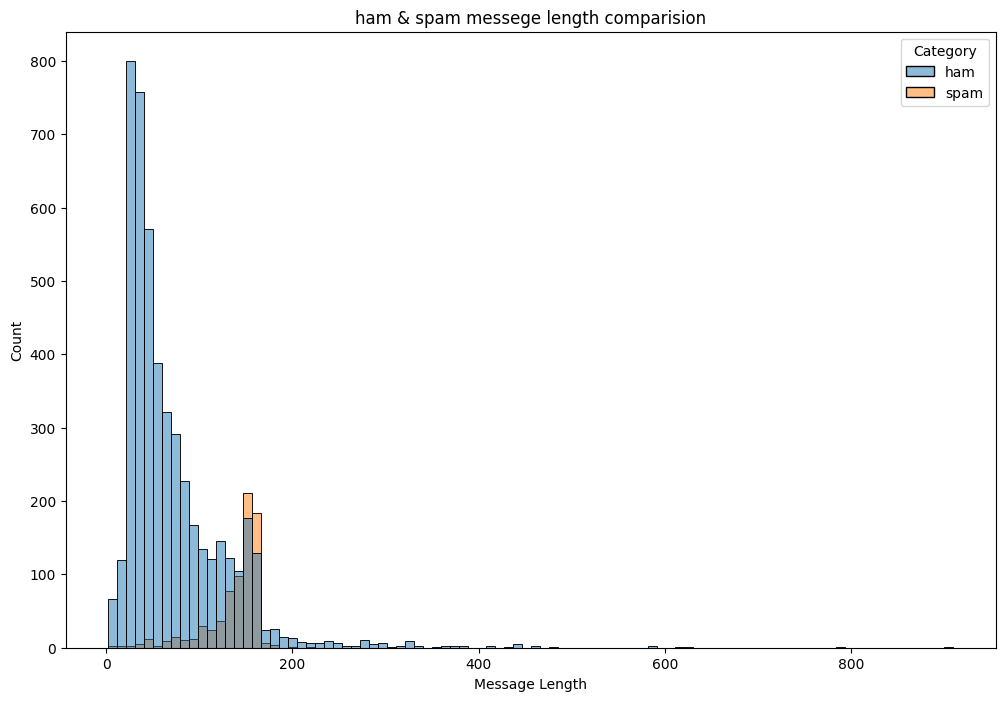

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


fig=plt.figure(figsize=(12,8))
sns.histplot(
    x=df["Message Length"],
    hue=df["Category"]
)
plt.title("ham & spam messege length comparision")
plt.show()

In [67]:
df["Category"].value_counts()

Category
ham     4825
spam     747
Name: count, dtype: int64

In [69]:
df["Label"]=df["Category"].map({"ham":0, "spam":1})

In [70]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stemmer=PorterStemmer()

In [71]:
corpus=[]

for message in df["Message"]:
    
    message=re.sub("[^a-zA-Z]"," ",message)
    
    message=message.lower()
    
    message=message.split()
    
    message=[stemmer.stem(words)
            for words in message
             if words not in set(stopwords.words("english"))
            ]
    
    message=" ".join(message)
    
    corpus.append(message)

In [72]:
from tensorflow.keras.preprocessing.text import one_hot
vocab_size=10000

oneHot_doc=[one_hot(words,n=vocab_size)
           for words in corpus
           ]

In [73]:
df["Message Length"].describe()


count    5572.000000
mean       80.368988
std        59.926946
min         2.000000
25%        35.750000
50%        61.000000
75%       122.000000
max       910.000000
Name: Message Length, dtype: float64

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


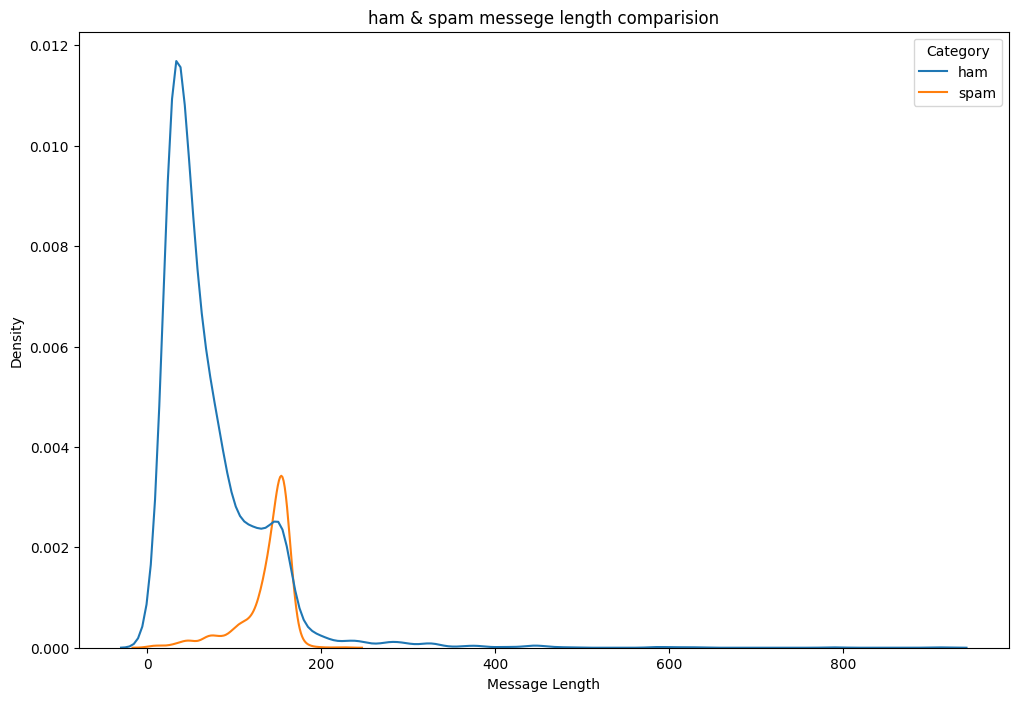

In [74]:
fig=plt.figure(figsize=(12,8))
sns.kdeplot(
    x=df["Message Length"],
    hue=df["Category"]
)
plt.title("ham & spam messege length comparision")
plt.show()

In [75]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
sentence_len=200
embedded_doc=pad_sequences(
    oneHot_doc,
    maxlen=sentence_len,
    padding="pre"
)

In [76]:
extract_features=pd.DataFrame(
    data=embedded_doc
)
target=df["Label"]
df_final=pd.concat([extract_features,target],axis=1)


In [77]:
df_final.head()


,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,Label
0,0,0,0,0,0,0,0,0,0,0,...,7734,3756,4050,2294,3158,1226,8328,8925,8485,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,4858,7637,1820,9304,8629,1244,0
2,0,0,0,0,0,0,0,0,0,0,...,4576,4590,8373,6220,9493,3428,7835,8595,4622,1
3,0,0,0,0,0,0,0,0,0,0,...,8629,1762,4866,9351,796,8629,8595,193,4866,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,8676,2467,7358,2774,1976,8234,5524,0


In [78]:
X=df_final.drop("Label",axis=1)
y=df_final["Label"]

In [79]:
from sklearn.model_selection import train_test_split
X_trainval,X_test,y_trainval,y_test=train_test_split(
    X,
    y,
    random_state=42,
    test_size=0.15
)

X_train,X_val,y_train,y_val=train_test_split(
    X_trainval,
    y_trainval,
    random_state=42,
    test_size=0.15
)

In [80]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential

model=Sequential()


In [81]:
feature_num=100
model.add(
    Embedding(
        input_dim=vocab_size,
        output_dim=feature_num,
        input_length=sentence_len
    )
)
model.add(
    LSTM(
    units=128
    )
)

model.add(
    Dense(
        units=1,
        activation="sigmoid"
    )
)

In [82]:
from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer=Adam(
    learning_rate=0.001
    ),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [83]:
model.fit(
    X_train,
    y_train,
    validation_data=(
        X_val,
        y_val
    ),
    epochs=10
)

Epoch 1/10
126/126 [==============================] - 24s 145ms/step - loss: 0.1804 - accuracy: 0.9416 - val_loss: 0.0664 - val_accuracy: 0.9789
Epoch 2/10
126/126 [==============================] - 7s 58ms/step - loss: 0.0360 - accuracy: 0.9891 - val_loss: 0.0530 - val_accuracy: 0.9803
Epoch 3/10
126/126 [==============================] - 4s 31ms/step - loss: 0.0117 - accuracy: 0.9965 - val_loss: 0.0648 - val_accuracy: 0.9859
Epoch 4/10
126/126 [==============================] - 3s 26ms/step - loss: 0.0069 - accuracy: 0.9983 - val_loss: 0.0624 - val_accuracy: 0.9803
Epoch 5/10
126/126 [==============================] - 3s 21ms/step - loss: 0.0025 - accuracy: 0.9993 - val_loss: 0.0760 - val_accuracy: 0.9873
Epoch 6/10
126/126 [==============================] - 3s 21ms/step - loss: 0.0018 - accuracy: 0.9998 - val_loss: 0.0676 - val_accuracy: 0.9873
Epoch 7/10
126/126 [==============================] - 3s 22ms/step - loss: 0.0012 - accuracy: 0.9998 - val_loss: 0.0602 - val_accuracy: 0.98

In [84]:
y_pred=model.predict(X_test)
y_pred=(y_pred>0.5)

27/27 [==============================] - 1s 5ms/step


In [85]:
from sklearn.metrics import accuracy_score,confusion_matrix

score=accuracy_score(y_test,y_pred)
print("Test Score:{:.2f}%".format(score*100))

Test Score:98.68%


array([[723,   6],
       [  5, 102]])

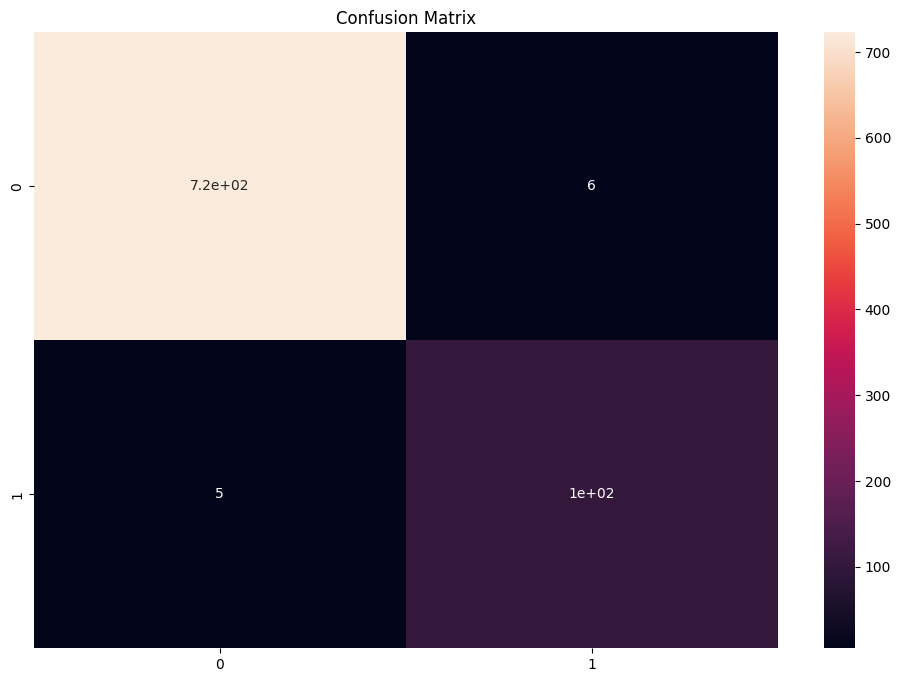

In [86]:
cm=confusion_matrix(y_test,y_pred)
fig=plt.figure(figsize=(12,8))
sns.heatmap(
    cm,
    annot=True,
)
plt.title("Confusion Matrix")
cm